In [29]:
import pandas as pd
import re
import gensim
import en_core_web_lg
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from gensim.utils import  simple_preprocess
import spacy
import gensim.corpora as corpora
from pprint import pprint
from gensim.models import CoherenceModel
from collections import Counter
from matplotlib import pyplot as plt
from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
stop_words = stopwords.words('english')
stop_words.extend(['well','let','from', 'subject', 'use', 'not', 'would', 'say', 'could', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [31]:
with open('Shakespeare.txt', encoding="utf8") as f:
    lines="".join(f.readlines())

docs=lines.split("\n")
docs=[doc for doc in docs if doc!=""]
indexes=[i-1 for i,val in enumerate(docs) if val=="Contents"]
titles=[docs[i] for i in indexes]
indexes.append(len(docs))
plays=[]
for i in range(len(indexes)-1):
    plays.append(docs[indexes[i]+1:indexes[i+1]])

plays_df=pd.DataFrame()
plays_df['Titles']=titles
plays_df['Plays']=[" ".join(play) for play in plays]


In [32]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)
        sent = re.sub('\s+', ' ', sent)
        sent = re.sub("\'", "", sent) 
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

data_words = list(sent_to_words(plays_df['Plays'].tolist()))

In [33]:
nlp = en_core_web_lg.load()

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN']):
    texts_out = []
    nlp = spacy.load("en_core_web_lg")
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc]) #if token.pos_ in allowed_postags])
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)

C:\Users\User\anaconda3\lib\site-packages\spacy\util.py:837: UserWarning: [W095] Model 'en_core_web_lg' (3.4.0) was trained with spaCy v3.4 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


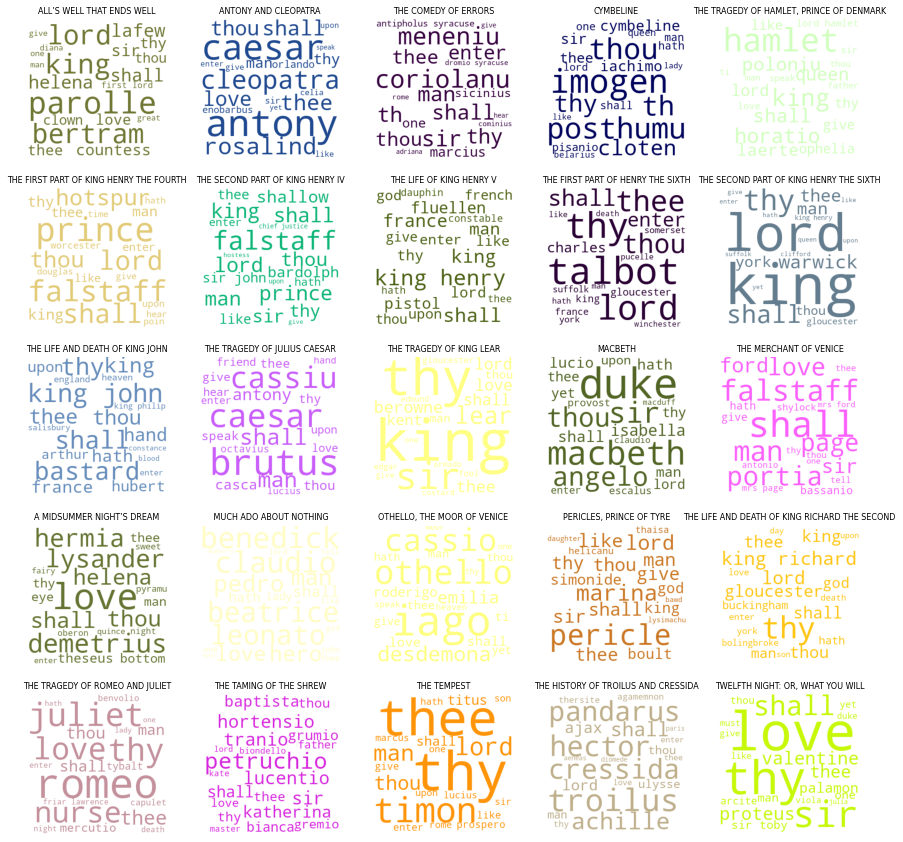

In [43]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors


cols = [color for name, color in (mcolors.TABLEAU_COLORS.items()| mcolors.XKCD_COLORS.items())] 

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=300,
                  height=300,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(5, 5, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    cloud.generate_from_text(" ".join(data_ready[i]))
    plt.gca().imshow(cloud)
    plt.gca().set_title(plays_df['Titles'][i], fontdict=dict(size=8))
    plt.gca().axis('off')
    


In [44]:
from gensim.models import Word2Vec

In [47]:
w2v_model = Word2Vec(min_count=10,
                     window=2,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=2)

w2v_model.build_vocab(data_ready, progress_per=10000)
w2v_model.train(data_ready, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(5663496, 13734780)

In [48]:
w2v_model.init_sims(replace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_23984\514372312.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [69]:
new_vec=w2v_model.wv["romeo"]-w2v_model.wv["man"]+w2v_model.wv["woman"]
w2v_model.wv.most_similar(new_vec)

[('romeo', 0.6975377798080444),
 ('juliet', 0.6875879168510437),
 ('nurse', 0.5908188223838806),
 ('girl', 0.5244743824005127),
 ('mistress', 0.5221123695373535),
 ('benvolio', 0.5126261115074158),
 ('capulet', 0.5065997838973999),
 ('shrift', 0.48216354846954346),
 ('sadness', 0.48212146759033203),
 ('woman', 0.4789673984050751)]